In [44]:
import cv2
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [30]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def image_composer(masks, image):
    mask = np.zeros((*masks.shape, 3))
    mask[:,:,0] = masks
    mask[:,:,1] = masks
    mask[:,:,2] = masks
    masked_img = image * mask
    return masked_img

def need_to_show(masks, image, text, target_tag, processor, clip_model):
    plot = np.zeros(len(masks), dtype=bool)
    for i in range(len(masks)):
        image_index = image_composer(masks[i]['segmentation'], image)

        inputs = processor(text=text, images=image_index, return_tensors="pt", padding=True)
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        if text[probs.argmax(1)] == target_tag:
            plot[i] = True
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            show_mask(masks[i]['segmentation'], plt.gca())
            plt.axis('off')
            plt.show()
    return plot

def show_anns_select(anns, plot):
    if len(anns) == 0:
        return

    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    sorted_plot = [plot[i] for i in np.argsort([-ann['area'] for ann in anns])]
    for i, ann in enumerate(sorted_anns):
        if sorted_plot[i]:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
    ax.imshow(img)


def show_masks_select(masks, plot):
    for i in range(len(masks)):
        if plot[i] == True:
            plt.figure(figsize=(10,10))
            show_mask(masks[i]['segmentation'], plt.gca())
            plt.axis('off')
            plt.show()



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
sam = sam_model_registry["vit_h"]("../model/sam_vit_h_4b8939.pth").to(device)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("Load Model successfully！")

Load Model successfully！


In [6]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [7]:
image = cv2.imread('../notebooks/images/sport_car.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

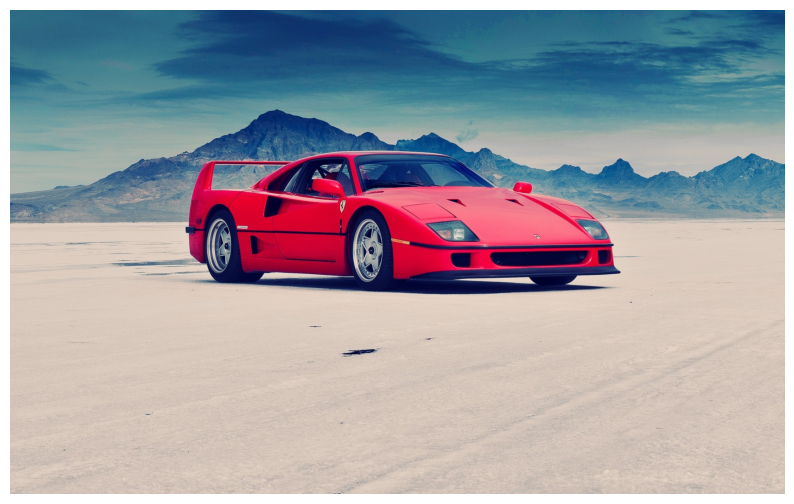

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
masks = mask_generator.generate(image)

In [10]:
print(len(masks))
print(masks[0].keys())

44
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


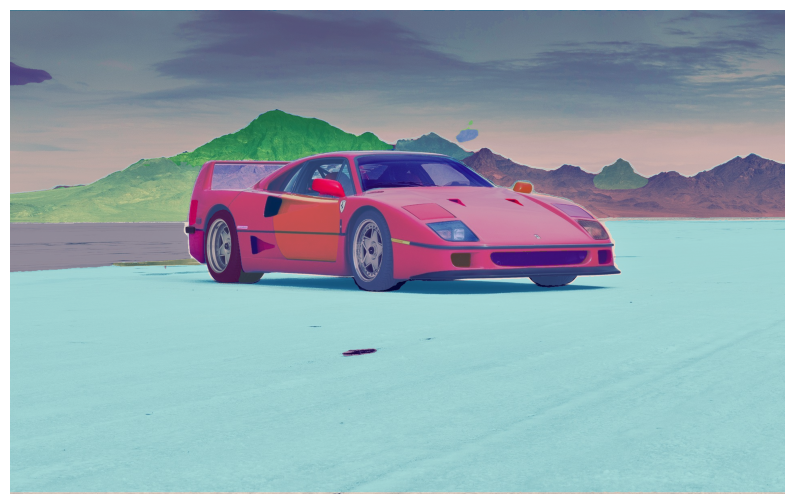

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [12]:
text = ['sport car', 'background', 'road', 'cars door', 'door', 'walkway', 'human', 'plastic', 'canvas', 'smoke', 'building', 'mountain', 'snow', 'animal', 'shadow', 'beach', 'sand']
target_tag = 'sport car'

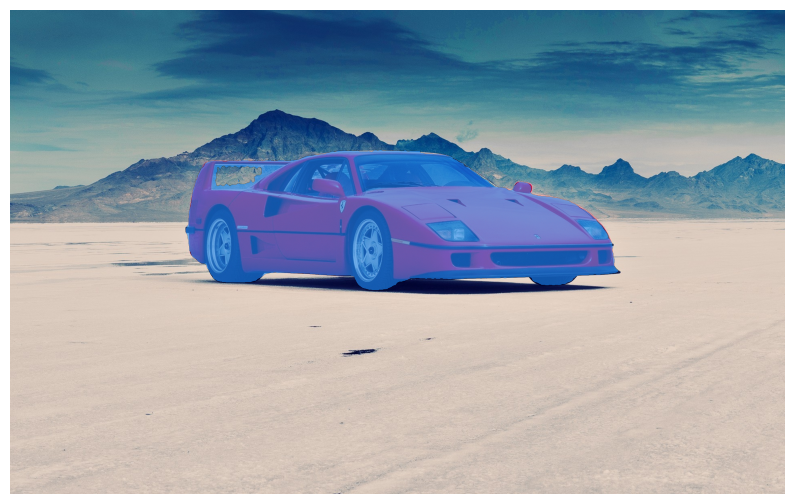

In [33]:
plot = need_to_show(masks, image, text, target_tag, processor, clip_model)

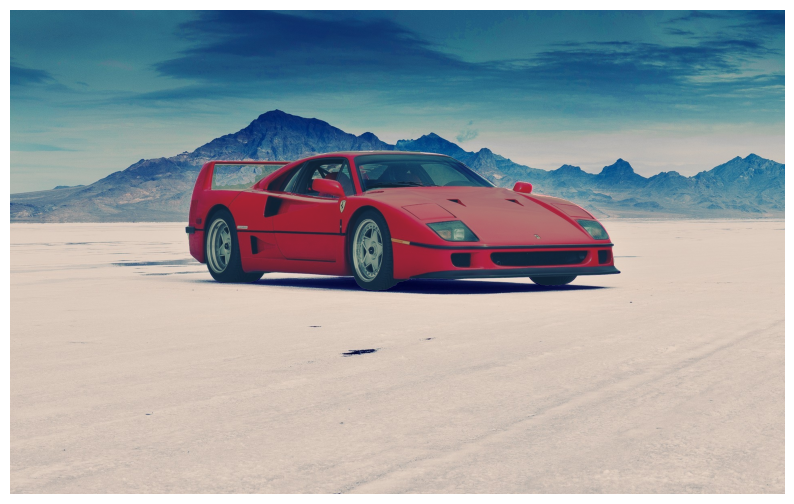

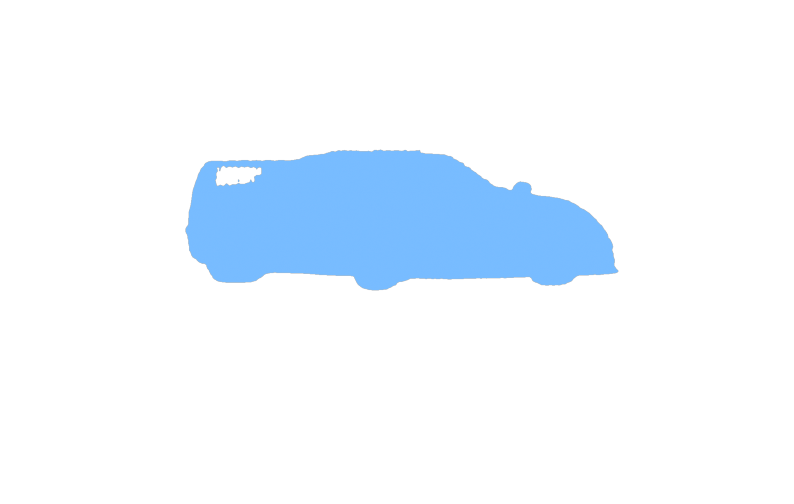

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns_select(masks, plot)
plt.axis('off')
plt.show()

show_masks_select(masks, plot)